In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [195]:
feature_df = pd.read_parquet('./model_features_2024-03-18.parquet')

In [4]:
feature_df.describe()

,id,lat,lng,pct_full,30m_fwd_pct_full_rel_change,month,day_of_week,hour,30m_blag_pct_full,120m_avg_pct_full,apparent_temperature,precipitation,wind_speed,30m_fwd_apparent_temperature,30m_fwd_precipitation
count,1.053471e+07,1.053471e+07,1.053471e+07,1.053471e+07,1.053471e+07,10534707.0,1.053471e+07,1.053471e+07,1.053471e+07,1.053471e+07,1.053471e+07,1.053471e+07,1.053471e+07,1.051464e+07,1.051464e+07
mean,5.006410e+08,2.418245e+01,1.209470e+02,3.619929e-01,-6.651928e-05,3.0,3.043800e+00,1.215539e+01,3.619369e-01,3.619111e-01,1.815781e+01,9.902714e-02,1.095640e+01,1.816908e+01,9.822274e-02
std,7.474727e+05,9.747819e-01,5.178422e-01,2.485133e-01,1.112938e-01,0.0,2.094778e+00,6.927501e+00,2.484449e-01,2.327391e-01,5.060608e+00,3.772521e-01,6.590320e+00,5.057212e+00,3.764847e-01
min,5.001010e+08,2.190000e+01,1.201000e+02,0.000000e+00,-1.000000e+00,3.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.658539e+00,0.000000e+00,3.600000e-01,4.658539e+00,0.000000e+00
25%,5.002070e+08,2.302000e+01,1.203900e+02,1.578947e-01,0.000000e+00,3.0,1.000000e+00,6.000000e+00,1.578947e-01,1.708333e-01,1.530383e+01,0.000000e+00,5.804825e+00,1.531222e+01,0.000000e+00
50%,5.006020e+08,2.444000e+01,1.208300e+02,3.333333e-01,0.000000e+00,3.0,3.000000e+00,1.300000e+01,3.333333e-01,3.333333e-01,1.807653e+01,0.000000e+00,9.470120e+00,1.808385e+01,0.000000e+00
75%,5.012031e+08,2.503000e+01,1.214900e+02,5.333333e-01,0.000000e+00,3.0,5.000000e+00,1.800000e+01,5.333333e-01,5.277778e-01,2.134244e+01,0.000000e+00,1.529470e+01,2.134244e+01,0.000000e+00
max,5.082010e+08,2.529000e+01,1.218700e+02,1.000000e+00,1.000000e+00,3.0,6.000000e+00,2.300000e+01,1.000000e+00,1.000000e+00,3.403964e+01,6.000000e+00,4.774040e+01,3.403964e+01,6.000000e+00


In [196]:
#TO Add to feature engineering
feature_df['coord'] = list(zip(feature_df['lat'], feature_df['lng']))
feature_df.drop(['lat','lng'], axis=1, inplace=True)
# feature_df.drop(['30m_blag_pct_full', '120m_avg_pct_full'], axis=1, inplace=True) # dropping for now because hard to update them when using a recursive predictive model

feature_df[['30m_fwd_precipitation', '30m_fwd_apparent_temperature']] = feature_df[['30m_fwd_precipitation', '30m_fwd_apparent_temperature']].ffill()

In [197]:
feature_df = feature_df.set_index(keys=['id','extraction_ts']).sort_index()


In [110]:
def get_X_Y(df, y_target):
    Y = df[y_target].copy(deep=True)
    X = df.drop(y_target, axis=1).copy(deep=True)
    return X, Y

In [190]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

In [205]:
def train_test_split_on_ts(df, split_ts: pd.Timestamp):
        train_df = df.loc[:, :split_ts, :].copy(deep=True)
        test_df = df.loc[:, split_ts:, :].copy(deep=True)
        return train_df, test_df


### Testing accuracy on one cluster of stations

In [269]:
s1 =  feature_df.loc[500119054:500119054, :,:].drop(['city', 'coord', 'month'], axis=1).copy(deep=True)

In [270]:
s1

pct_full  30m_fwd_pct_full_rel_change  \
id        extraction_ts                                                      
500119054 2024-03-01 12:02:43+08:00  0.733333                    -0.100000   
          2024-03-01 12:07:47+08:00  0.800000                    -0.033333   
          2024-03-01 12:18:48+08:00  0.800000                    -0.033333   
          2024-03-01 12:23:52+08:00  0.833333                     0.033333   
          2024-03-01 12:28:57+08:00  0.833333                     0.033333   
...                                       ...                          ...   
          2024-03-18 22:40:58+08:00  0.000000                     0.000000   
          2024-03-18 22:50:49+08:00  0.000000                     0.000000   
          2024-03-18 23:01:06+08:00  0.000000                     0.000000   
          2024-03-18 23:10:56+08:00  0.000000                    -0.033333   
          2024-03-18 23:21:02+08:00  0.000000                     0.000000   

                                     day_of_week  hour  30m_blag_pct_full  \
id        extraction_ts                                                     
500119054 2024-03-01 12:02:43+08:00            4    12           0.833333   
          2024-03-01 12:07:47+08:00            4    12           0.800000   
          2024-03-01 12:18:48+08:00            4    12           0.800000   
          2024-03-01 12:23:52+08:00            4    12           0.733333   
          2024-03-01 12:28:57+08:00            4    12           0.800000   
...                                          ...   ...                ...   
          2024-03-18 22:40:58+08:00            0    22           0.000000   
          2024-03-18 22:50:49+08:00            0    22           0.000000   
          2024-03-18 23:01:06+08:00            0    23           0.000000   
          2024-03-18 23:10:56+08:00            0    23           0.000000   
          2024-03-18 23:21:02+08:00            0    23           0.000000   

                                     120m_avg_pct_full  apparent_temperature  \
id        extraction_ts                                                        
500119054 2024-03-01 12:02:43+08:00           0.683333             10.421238   
          2024-03-01 12:07:47+08:00           0.750000             10.421238   
          2024-03-01 12:18:48+08:00           0.761111             10.421238   
          2024-03-01 12:23:52+08:00           0.775000             10.421238   
          2024-03-01 12:28:57+08:00           0.791667             10.421238   
...                                                ...                   ...   
          2024-03-18 22:40:58+08:00           0.008333             17.121902   
          2024-03-18 22:50:49+08:00           0.008333             17.121902   
          2024-03-18 23:01:06+08:00           0.005556             17.571507   
          2024-03-18 23:10:56+08:00           0.002778             17.571507   
          2024-03-18 23:21:02+08:00           0.002778             17.571507   

                                     precipitation  wind_speed  \
id        extraction_ts                                          
500119054 2024-03-01 12:02:43+08:00            0.6   19.486609   
          2024-03-01 12:07:47+08:00            0.6   19.486609   
          2024-03-01 12:18:48+08:00            0.6   19.486609   
          2024-03-01 12:23:52+08:00            0.6   19.486609   
          2024-03-01 12:28:57+08:00            0.6   19.486609   
...                                            ...         ...   
          2024-03-18 22:40:58+08:00            0.0   13.441071   
          2024-03-18 22:50:49+08:00            0.0   13.441071   
          2024-03-18 23:01:06+08:00            0.0    7.968939   
          2024-03-18 23:10:56+08:00            0.0    7.968939   
          2024-03-18 23:21:02+08:00            0.0    7.968939   

                                     30m_fwd_apparent_temperature  \
id        extraction_ts                            

In [271]:

# train - test split Own implementation
cutoff_date = pd.to_datetime('2024-03-15', yearfirst=True).tz_localize(tz="Asia/Taipei")

s1_train, s1_test = train_test_split_on_ts(s1, cutoff_date)


X_train, y_train = get_X_Y(s1_train, '30m_fwd_pct_full_rel_change')
X_test, y_test = get_X_Y(s1_test, '30m_fwd_pct_full_rel_change')

In [272]:
model = Ridge()

In [273]:
model.fit(X_train, y_train)

Ridge()

In [280]:
y_hat = model.predict(X_test)

In [191]:
y_hat

array([ 0.0803168 ,  0.0803168 ,  0.0803168 , ..., -0.02739497,
       -0.02739497, -0.02739497])

In [173]:
id_to_review = np.random.choice(
    np.array(X_train.index.get_level_values(level=0)),
    1)

In [277]:
id_to_review = [500119054]

In [278]:
rand_station_train = s1_train.loc[id_to_review, :, :].iloc[-400:]
rand_station_test = s1_test.loc[id_to_review, :, :]

[500119054]

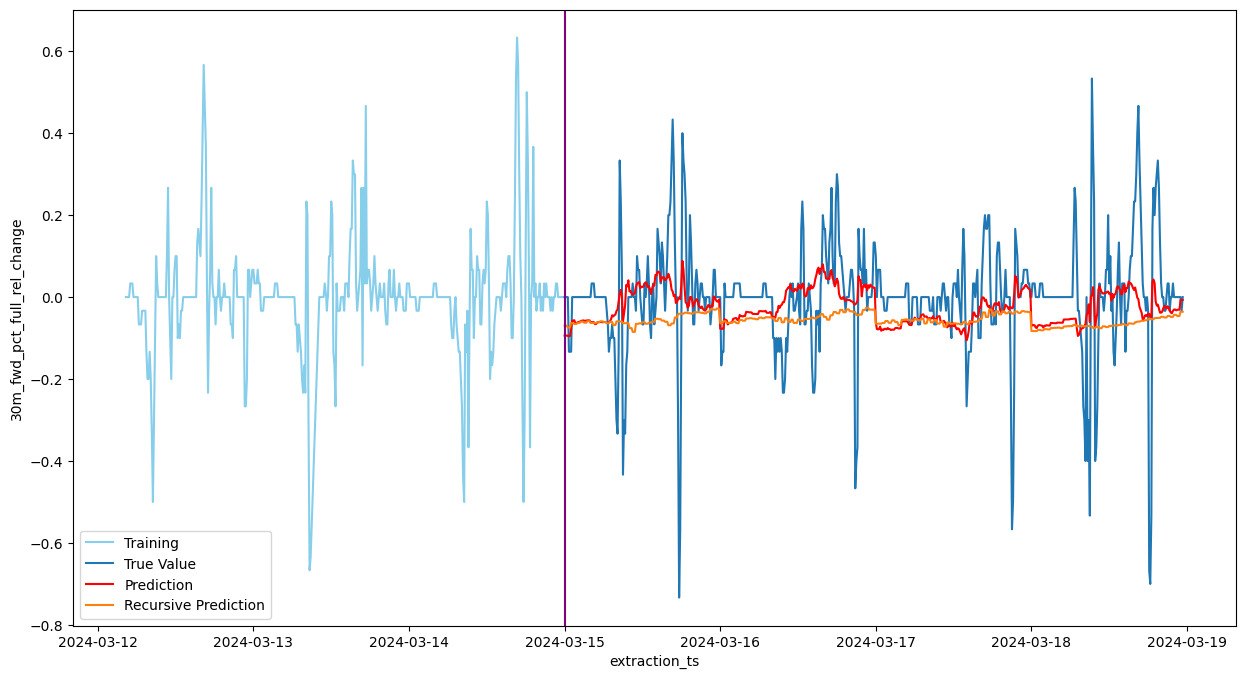

In [279]:

fig, ax = plt.subplots(1, 1, figsize=(15,8))
# sns.scatterplot( x=X_train.index.get_level_values(level=1), y=y_train, hue=X_train.index.get_level_values(level=0), ax=ax)
sns.lineplot(x=rand_station_train.index.get_level_values(level=1),
             y=rand_station_train['30m_fwd_pct_full_rel_change'],
             ax=ax, label='Training', color='skyblue')
sns.lineplot(x=rand_station_test.index.get_level_values(level=1),
             y=rand_station_test['30m_fwd_pct_full_rel_change'],
             ax=ax, label='True Value')

sns.lineplot(x=X_test.loc[id_to_review, :, :].index.get_level_values(level=1),
             y=model.predict(X_test.loc[id_to_review, :, :]),
             ax=ax, label='Prediction', color='red'
            )

sns.lineplot(x=rand_station_test.index.get_level_values(level=1),
             y=predicted_y,
             ax=ax, label='Recursive Prediction')
ax.axvline(rand_station_test.index.get_level_values(level=1)[0], color='purple')

display(id_to_review)

In [282]:
#For 500119054
r2_score_500119054 = r2_score(y_hat, y_test)
display(r2_score_500119054)

-9.963831606134834

In [193]:
# Without time lag features
no_time_lag_r2 = r2_score(y_hat, y_test)
display(no_time_lag_r2)

-10.50766960909043

In [203]:
# With time lag features
with_time_lag_r2 = r2_score(y_hat, y_test)
display(with_time_lag_r2)

-9.995554446443144

#### Predict recursively

In [145]:
# Given a unique station ID and sorted ts

In [177]:
X_rand_station, Y_rand_station = get_X_Y(rand_station_test, '30m_fwd_pct_full_rel_change')

In [147]:
def predict_recursively(model, X, t1_label):
    
    model.predict(

SyntaxError: incomplete input (1155182390.py, line 3)

In [180]:
predicted_y = []
pct_full_true = X_rand_station['pct_full'].copy(deep=True)
t1_updated_pct_full = None
for i, r in X_rand_station.iloc[:].iterrows():
    if t1_updated_pct_full is not None:
        # print(f"Updating pct_full from {r['pct_full']} to {t1_updated_pct_full}")
        r['pct_full'] = t1_updated_pct_full
    t1_rel_change =  model.predict(r.to_frame().T)[0]
    # print(f"t1_rel_change {t1_rel_change}")
    
    predicted_y.append(t1_rel_change)
    planned_update = r['pct_full'] + t1_rel_change
    t1_updated_pct_full = np.where(planned_update < 0, 0, planned_update)
predicted_y = np.array(predicted_y)    

## Predict on whole dataset - Dumb Model

In [245]:
cutoff_date = pd.to_datetime('2024-03-15', yearfirst=True).tz_localize(tz="Asia/Taipei")
train_df, test_df = train_test_split_on_ts(
    feature_df.drop(['city', 'coord', 'month'], axis=1),
    cutoff_date)

In [240]:
X_train, y_train = get_X_Y(train_df, "30m_fwd_pct_full_rel_change")
X_test, y_test = get_X_Y(test_df, "30m_fwd_pct_full_rel_change")

In [217]:
ridge_entire_data = Ridge()

In [218]:
ridge_entire_data.fit(X_train, y_train)

Ridge()

In [227]:
y_hat = ridge_entire_data.predict(X_test)

In [241]:
X_train.index.get_level_values(level=0).unique()

Index([500101001, 500101002, 500101003, 500101004, 500101005, 500101006,
       500101007, 500101008, 500101009, 500101010,
       ...
       508201032, 508201033, 508201034, 508201035, 508201036, 508201037,
       508201038, 508201039, 508201040, 508201041],
      dtype='int64', name='id', length=6677)

In [252]:
filter_station_train.index.get_level_values(level=0)

DatetimeIndex(['2024-03-01 12:02:43+08:00', '2024-03-01 12:07:47+08:00',
               '2024-03-01 12:18:48+08:00', '2024-03-01 12:23:52+08:00',
               '2024-03-01 12:28:57+08:00', '2024-03-01 12:34:01+08:00',
               '2024-03-01 12:39:05+08:00', '2024-03-01 12:44:10+08:00',
               '2024-03-01 12:49:15+08:00', '2024-03-01 12:54:19+08:00',
               ...
               '2024-03-14 22:20:56+08:00', '2024-03-14 22:30:55+08:00',
               '2024-03-14 22:40:51+08:00', '2024-03-14 22:50:59+08:00',
               '2024-03-14 23:00:58+08:00', '2024-03-14 23:11:00+08:00',
               '2024-03-14 23:20:54+08:00', '2024-03-14 23:30:53+08:00',
               '2024-03-14 23:40:55+08:00', '2024-03-14 23:50:51+08:00'],
              dtype='datetime64[ns, Asia/Taipei]', name='extraction_ts', length=1011, freq=None)

In [259]:
id_to_review = 500119054


500119054

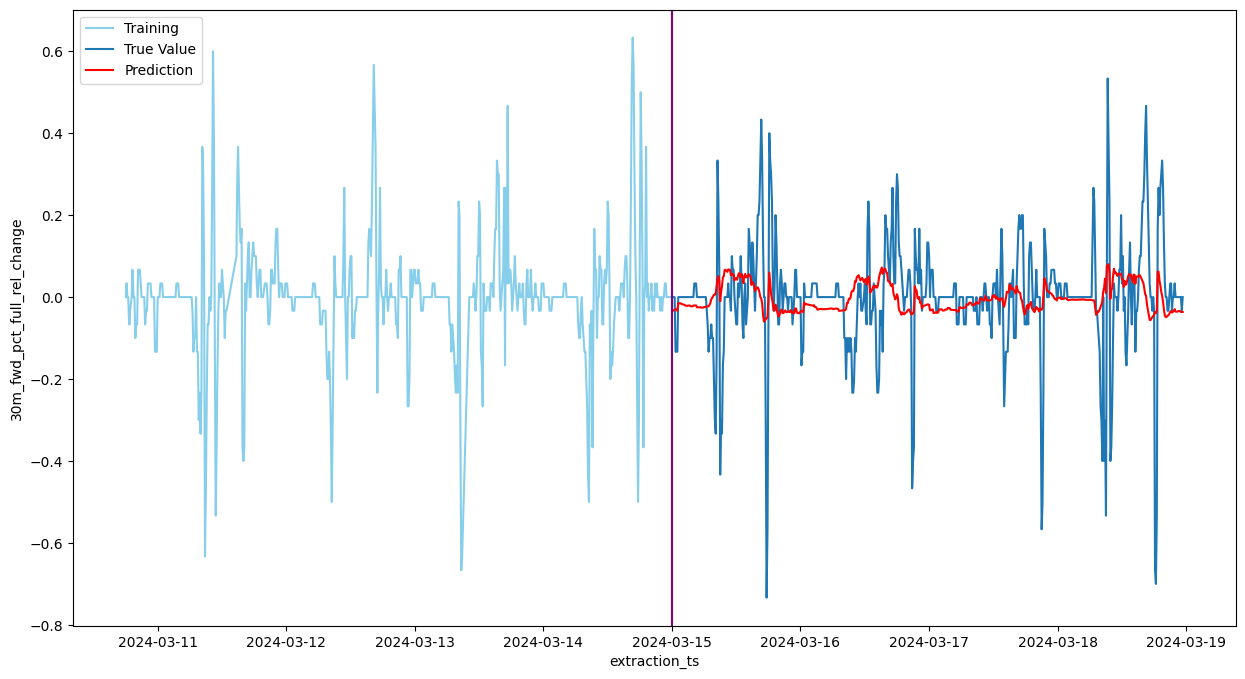

In [260]:
filter_station_train = train_df.loc[id_to_review,:,:].iloc[-600:]
filter_station_test = test_df.loc[id_to_review,:,:]

fig, ax = plt.subplots(1, 1, figsize=(15,8))
sns.lineplot(x=filter_station_train.index.get_level_values(level=0),
             y=filter_station_train['30m_fwd_pct_full_rel_change'],
             ax=ax, label='Training', color='skyblue')

sns.lineplot(x=filter_station_test.index.get_level_values(level=0),
             y=filter_station_test['30m_fwd_pct_full_rel_change'],
             ax=ax, label='True Value')

sns.lineplot(x=X_test.loc[id_to_review, :, :].index.get_level_values(level=0),
             y=ridge_entire_data.predict(X_test.loc[id_to_review, :, :]),
             ax=ax, label='Prediction', color='red'
            )


ax.axvline(filter_station_test.index.get_level_values(level=0)[0], color='purple')

display(id_to_review)

In [231]:
r2_score(y_hat, y_test)

-15.060581137983057

In [285]:
X_train

pct_full  day_of_week  hour  \
id        extraction_ts                                            
500119054 2024-03-01 12:02:43+08:00  0.733333            4    12   
          2024-03-01 12:07:47+08:00  0.800000            4    12   
          2024-03-01 12:18:48+08:00  0.800000            4    12   
          2024-03-01 12:23:52+08:00  0.833333            4    12   
          2024-03-01 12:28:57+08:00  0.833333            4    12   
...                                       ...          ...   ...   
          2024-03-14 23:11:00+08:00  0.000000            3    23   
          2024-03-14 23:20:54+08:00  0.000000            3    23   
          2024-03-14 23:30:53+08:00  0.000000            3    23   
          2024-03-14 23:40:55+08:00  0.000000            3    23   
          2024-03-14 23:50:51+08:00  0.000000            3    23   

                                     30m_blag_pct_full  120m_avg_pct_full  \
id        extraction_ts                                                     
500119054 2024-03-01 12:02:43+08:00           0.833333           0.683333   
          2024-03-01 12:07:47+08:00           0.800000           0.750000   
          2024-03-01 12:18:48+08:00           0.800000           0.761111   
          2024-03-01 12:23:52+08:00           0.733333           0.775000   
          2024-03-01 12:28:57+08:00           0.800000           0.791667   
...                                                ...                ...   
          2024-03-14 23:11:00+08:00           0.033333           0.008333   
          2024-03-14 23:20:54+08:00           0.033333           0.008333   
          2024-03-14 23:30:53+08:00           0.000000           0.008333   
          2024-03-14 23:40:55+08:00           0.000000           0.008333   
          2024-03-14 23:50:51+08:00           0.000000           0.008333   

                                     apparent_temperature  precipitation  \
id        extraction_ts                                                    
500119054 2024-03-01 12:02:43+08:00             10.421238            0.6   
          2024-03-01 12:07:47+08:00             10.421238            0.6   
          2024-03-01 12:18:48+08:00             10.421238            0.6   
          2024-03-01 12:23:52+08:00             10.421238            0.6   
          2024-03-01 12:28:57+08:00             10.421238            0.6   
...                                                   ...            ...   
          2024-03-14 23:11:00+08:00             18.527359            0.0   
          2024-03-14 23:20:54+08:00             18.527359            0.0   
          2024-03-14 23:30:53+08:00             18.527359            0.0   
          2024-03-14 23:40:55+08:00             18.527359            0.0   
          2024-03-14 23:50:51+08:00             18.527359            0.0   

                                     wind_speed  30m_fwd_apparent_temperature  \
id        extraction_ts                                                         
500119054 2024-03-01 12:02:43+08:00   19.486609                     10.421238   
          2024-03-01 12:07:47+08:00   19.486609                     10.421238   
          2024-03-01 12:18:48+08:00   19.486609                     10.421238   
          2024-03-01 12:23:52+08:00   19.486609                     10.421238   
          2024-03-01 12:28:57+08:00   19.486609                     10.421238   
...                                         ...                           ...   
          2024-03-14 23:11:00+08:00    9.021574                     18.527359   
          2024-03-14 23:20:54+08:00    9.021574                     18.527359   
          2024-03-14 23:30:53+08:00    9.021574                     18.785100   
          2024-03-14 23:40:55+08:00    9.021574                     18.785100   
          2024-03-14 23:50:51+08:00    9.021574                     18.785100   

                                     30m_fwd_precipitation  
id        extraction_ts                       

In [287]:
ridge_entire_data.get_params()

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.0001}

# Save Model

In [291]:
import pickle

In [294]:
with open('./model_2024-03-19.pkl', 'wb') as f:
    pickle.dump(ridge_entire_data, f)